# Hidden Markov Model Regime Detection for Credit Spread Mean Reversion

**Objective:** Identify latent market regimes that modulate the strength and speed of credit spread mean reversion.

**Hypothesis:** Credit spread mean reversion is state-dependent. A two-regime Hidden Markov Model applied to macro-financial conditions can identify periods where mean reversion dynamics differ materially.

**Scope:** This notebook establishes the statistical foundation for regime-conditional mean reversion. Trading implementation is explicitly deferred.

---

## 1. Introduction

### 1.1 Motivation

Credit spreads exhibit time-varying mean reversion. The hypothesis tested here is that macroeconomic and financial stress conditions induce discrete regime shifts in mean reversion dynamics. We employ a Hidden Markov Model (HMM) to infer these latent regimes from observable macro-financial variables.

**Key distinction:** Stress does not eliminate mean reversion. Rather, stress alters the half-life, volatility, and conditional expected returns of the mean-reverting process.

### 1.2 Methodology

We fit a 2-state Gaussian HMM to a feature set comprising:
- VIX (equity market uncertainty)
- ANFCI (Adjusted National Financial Conditions Index)
- Term spread (10Y - 2Y yields)
- Dollar strength (trade-weighted USD index)
- Credit spread absolute change
- Credit spread realized volatility

The model infers two latent states. We then test whether mean reversion dynamics differ across these states using:
- Median regression (robust to fat tails)
- Bootstrap confidence intervals (distribution-free inference)
- Half-life estimation in each regime

### 1.3 Signal Definition

The spread signal is the **BofA Merrill Lynch US Corporate Master Option-Adjusted Spread (BAMLC0A0CM)**. This is a market-wide credit spread index, not a tradable instrument pair. Execution via LQD/IEF is addressed separately in the trading proof-of-concept.

---

## 2. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg
from hmmlearn import hmm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Output directories
Path('../results/hmm_research').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

# Professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

np.random.seed(42)

In [2]:
# Load processed data
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)

# Subset to analysis period
df_analysis = df.loc['2015-01-01':'2024-12-31'].copy()

print(f"Analysis period: {df_analysis.index.min().date()} to {df_analysis.index.max().date()}")
print(f"Observations: {len(df_analysis)}")
print(f"\nFeatures available: {df_analysis.columns.tolist()}")

Analysis period: 2015-01-29 to 2024-12-31
Observations: 2624

Features available: ['spread', 'vix', 'anfci', 'dgs10', 'dgs2', 'dgs3mo', 'dtwexbgs', 'regime', 'hmm_realized_vol', 'hmm_abs_change', 'hmm_stress_interaction', 'hmm_term_spread', 'hmm_dollar_strength']


## 3. Feature Engineering for HMM

We construct standardized features that capture macro-financial stress conditions. Each feature is normalized to facilitate HMM convergence.

In [3]:
# Compute additional features
df_analysis['spread_change_abs'] = df_analysis['spread'].diff().abs()
df_analysis['spread_vol_20d'] = df_analysis['spread'].rolling(20).std()
df_analysis['term_spread'] = df_analysis['dgs10'] - df_analysis['dgs2']

# Drop initial NaN rows
df_analysis = df_analysis.dropna()

# Select features for HMM
feature_cols = [
    'vix',
    'anfci',
    'term_spread',
    'dtwexbgs',  # Dollar index
    'spread_change_abs',
    'spread_vol_20d'
]

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_analysis[feature_cols])

print(f"Feature matrix shape: {features_scaled.shape}")
print(f"\nFeature summary:")
print(pd.DataFrame(features_scaled, columns=feature_cols).describe().T[['mean', 'std', 'min', 'max']])

Feature matrix shape: (2605, 6)

Feature summary:
                           mean       std       min        max
vix               -2.182089e-16  1.000192 -1.247405   8.826231
anfci             -2.836716e-16  1.000192 -1.546510   5.079487
term_spread       -8.728356e-17  1.000192 -2.346853   1.976605
dtwexbgs          -3.011283e-15  1.000192 -2.342634   2.687387
spread_change_abs -3.273134e-17  1.000192 -0.470747  20.067350
spread_vol_20d    -1.091045e-17  1.000192 -0.486176  12.885866


## 4. Hidden Markov Model Estimation

We fit a 2-state Gaussian HMM using the Baum-Welch algorithm (Expectation-Maximization). The model infers:

- **State sequence:** Latent regime at each time $t$
- **Transition probabilities:** $P(s_t = j | s_{t-1} = i)$
- **Emission parameters:** Gaussian means and covariances for each state

Model specification:
- States: 2 (low stress, high stress)
- Covariance type: Full (allows correlation between features)
- Initialization: K-means on feature space

In [4]:
# Fit HMM
n_states = 2
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type='full',
    n_iter=1000,
    random_state=42,
    init_params='stmc'
)

model.fit(features_scaled)

# Predict regime sequence
regimes = model.predict(features_scaled)
df_analysis['regime'] = regimes

# Identify which state corresponds to high stress
# Use VIX mean as discriminator
regime_vix_mean = df_analysis.groupby('regime')['vix'].mean()
high_stress_regime = regime_vix_mean.idxmax()
low_stress_regime = regime_vix_mean.idxmin()

# Relabel so that regime 1 = high stress, regime 0 = low stress
regime_map = {high_stress_regime: 1, low_stress_regime: 0}
df_analysis['regime'] = df_analysis['regime'].map(regime_map)

print(f"Model converged: Log-likelihood = {model.score(features_scaled):.2f}")
print(f"\nRegime distribution:")
print(df_analysis['regime'].value_counts().sort_index())
print(f"\nRegime 0 (Low Stress): {(df_analysis['regime']==0).sum()} days ({(df_analysis['regime']==0).mean()*100:.1f}%)")
print(f"Regime 1 (High Stress): {(df_analysis['regime']==1).sum()} days ({(df_analysis['regime']==1).mean()*100:.1f}%)")

Model converged: Log-likelihood = -13230.57

Regime distribution:
regime
0    2223
1     382
Name: count, dtype: int64

Regime 0 (Low Stress): 2223 days (85.3%)
Regime 1 (High Stress): 382 days (14.7%)


## 5. Regime Characterization

We examine the empirical properties of each inferred regime to validate economic interpretation.

In [5]:
# Regime statistics
regime_stats = df_analysis.groupby('regime')[feature_cols + ['spread']].agg(['mean', 'std', 'median'])

print("Regime Characteristics (Mean Values):")
print("=" * 80)
regime_means = regime_stats.xs('mean', axis=1, level=1).T
regime_means.columns = ['Low Stress (0)', 'High Stress (1)']
regime_means['Diff (%)'] = (regime_means['High Stress (1)'] - regime_means['Low Stress (0)']) / regime_means['Low Stress (0)'] * 100
print(regime_means.round(3))

Regime Characteristics (Mean Values):
                   Low Stress (0)  High Stress (1)  Diff (%)
vix                        16.424           28.861    75.729
anfci                      -0.464           -0.177   -61.907
term_spread                 0.504            0.254   -49.549
dtwexbgs                  115.209          119.791     3.977
spread_change_abs           0.007            0.032   340.019
spread_vol_20d              0.027            0.127   365.138
spread                      1.203            1.705    41.765


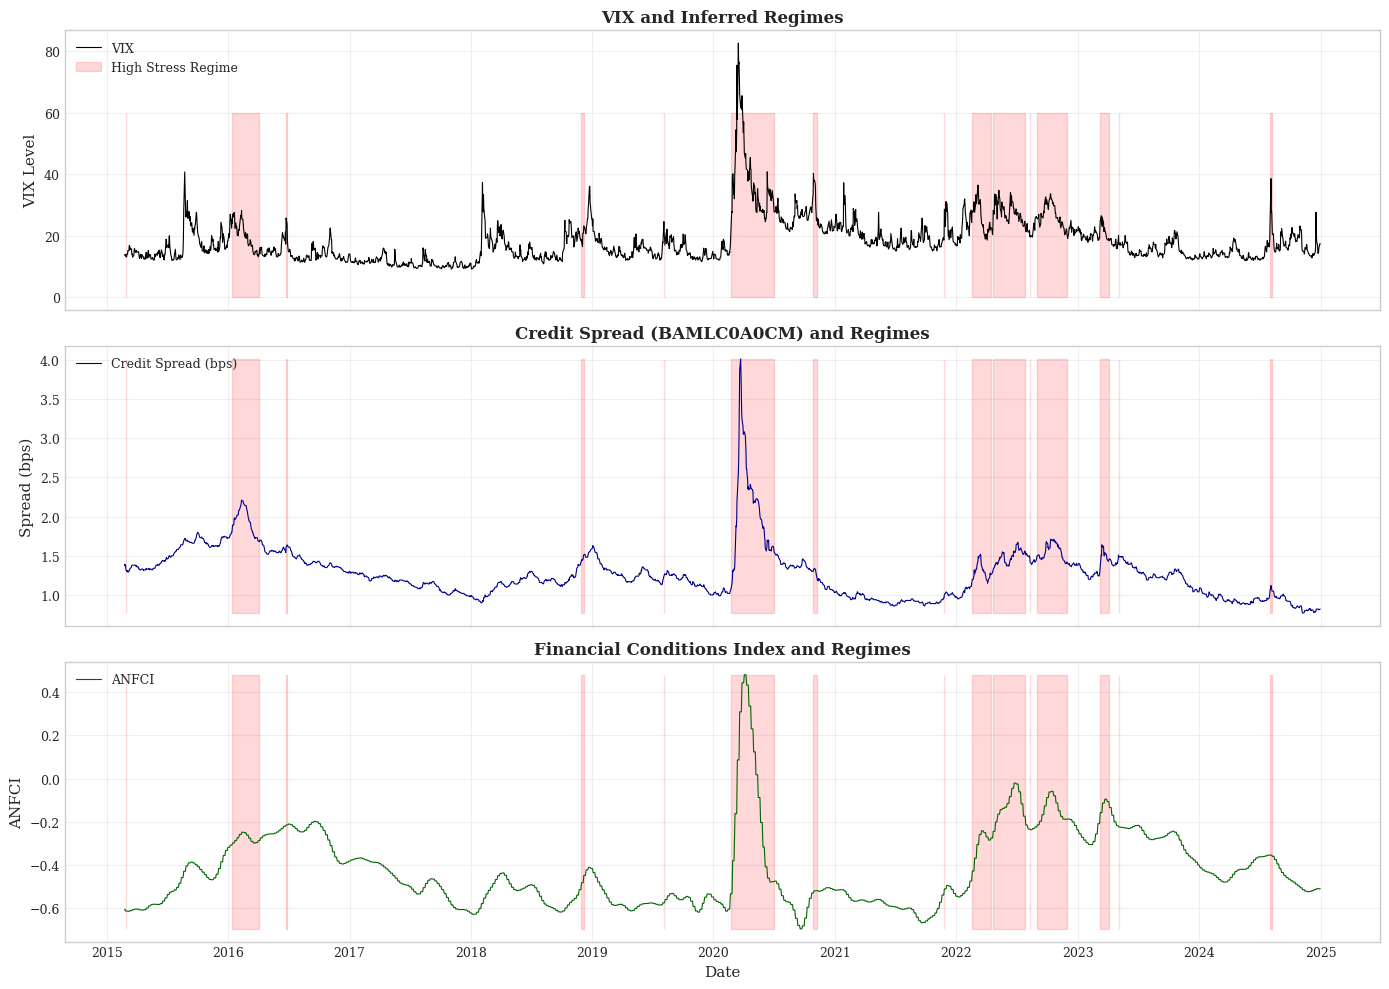

In [6]:
# Visualize regime time series
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: VIX with regime shading
ax = axes[0]
ax.plot(df_analysis.index, df_analysis['vix'], color='black', linewidth=0.8, label='VIX')
high_stress = df_analysis['regime'] == 1
ax.fill_between(df_analysis.index, 0, 60, where=high_stress, 
                 alpha=0.15, color='red', label='High Stress Regime')
ax.set_ylabel('VIX Level')
ax.set_title('VIX and Inferred Regimes', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Panel 2: Credit spread with regime shading
ax = axes[1]
ax.plot(df_analysis.index, df_analysis['spread'], color='darkblue', linewidth=0.8, label='Credit Spread (bps)')
ax.fill_between(df_analysis.index, df_analysis['spread'].min(), df_analysis['spread'].max(), 
                 where=high_stress, alpha=0.15, color='red')
ax.set_ylabel('Spread (bps)')
ax.set_title('Credit Spread (BAMLC0A0CM) and Regimes', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Panel 3: ANFCI with regime shading
ax = axes[2]
ax.plot(df_analysis.index, df_analysis['anfci'], color='darkgreen', linewidth=0.8, label='ANFCI')
ax.fill_between(df_analysis.index, df_analysis['anfci'].min(), df_analysis['anfci'].max(), 
                 where=high_stress, alpha=0.15, color='red')
ax.set_ylabel('ANFCI')
ax.set_xlabel('Date')
ax.set_title('Financial Conditions Index and Regimes', fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/hmm_regime_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Mean Reversion Tests: Regime-Conditional

We test the null hypothesis that spread changes are unpredictable (random walk) against the alternative of mean reversion. Tests are conducted separately for each regime.

### 6.1 Methodology

For horizon $h$, we estimate:

$$\Delta S_{t,t+h} = \alpha + \beta S_t + \epsilon_t$$

where:
- $S_t$ is the spread level at time $t$
- $\Delta S_{t,t+h} = S_{t+h} - S_t$ is the spread change over $h$ days
- Mean reversion implies $\beta < 0$

We use **median regression** (quantile regression at $\tau = 0.5$) for robustness to outliers and fat tails. Bootstrap resampling provides distribution-free confidence intervals.

In [7]:
def test_mean_reversion_median(
    data: pd.DataFrame,
    horizon: int,
    regime: int = None,
    n_bootstrap: int = 1000
) -> dict:
    """
    Test mean reversion using median regression with bootstrap inference.
    
    Parameters
    ----------
    data : DataFrame with 'spread' and 'regime' columns
    horizon : forecast horizon in days
    regime : filter to specific regime (None = unconditional)
    n_bootstrap : number of bootstrap samples
    
    Returns
    -------
    dict with beta, t-stat, p-value, and confidence interval
    """
    # Filter by regime if specified
    if regime is not None:
        data_reg = data[data['regime'] == regime].copy()
    else:
        data_reg = data.copy()
    
    # Construct variables
    data_reg['spread_change'] = data_reg['spread'].shift(-horizon) - data_reg['spread']
    data_reg = data_reg.dropna()
    
    if len(data_reg) < 30:
        return {'beta': np.nan, 't_stat': np.nan, 'p_value': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan, 'n_obs': len(data_reg)}
    
    # Median regression
    X = data_reg['spread'].values
    y = data_reg['spread_change'].values
    
    # Add constant
    X_const = np.column_stack([np.ones(len(X)), X])
    
    mod = QuantReg(y, X_const)
    res = mod.fit(q=0.5, max_iter=1000)
    
    beta_hat = res.params[1]
    
    # Bootstrap for inference
    beta_boot = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X_const[idx]
        y_boot = y[idx]
        try:
            res_boot = QuantReg(y_boot, X_boot).fit(q=0.5, max_iter=1000)
            beta_boot.append(res_boot.params[1])
        except:
            continue
    
    beta_boot = np.array(beta_boot)
    
    # Compute statistics
    se_boot = np.std(beta_boot)
    t_stat = beta_hat / se_boot if se_boot > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    ci_lower = np.percentile(beta_boot, 2.5)
    ci_upper = np.percentile(beta_boot, 97.5)
    
    return {
        'beta': beta_hat,
        't_stat': t_stat,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_obs': len(data_reg),
        'se': se_boot
    }

In [8]:
# Test across multiple horizons
horizons = [5, 10, 21, 42, 63]
results_list = []

for h in horizons:
    # Unconditional
    res_uncond = test_mean_reversion_median(df_analysis, horizon=h, regime=None, n_bootstrap=1000)
    results_list.append({'horizon': h, 'regime': 'Unconditional', **res_uncond})
    
    # Low stress
    res_low = test_mean_reversion_median(df_analysis, horizon=h, regime=0, n_bootstrap=1000)
    results_list.append({'horizon': h, 'regime': 'Low Stress', **res_low})
    
    # High stress
    res_high = test_mean_reversion_median(df_analysis, horizon=h, regime=1, n_bootstrap=1000)
    results_list.append({'horizon': h, 'regime': 'High Stress', **res_high})

results_df = pd.DataFrame(results_list)

print("\nMean Reversion Tests: Median Regression with Bootstrap")
print("=" * 100)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('../results/hmm_research/regime_mean_reversion_tests.csv', index=False)


Mean Reversion Tests: Median Regression with Bootstrap
 horizon        regime      beta     t_stat      p_value  ci_lower  ci_upper  n_obs       se
       5 Unconditional -0.020412  -4.436551 9.141179e-06 -0.030299 -0.013521   2600 0.004601
       5    Low Stress -0.012987  -3.093836 1.975865e-03 -0.019242 -0.000008   2218 0.004198
       5   High Stress -0.169806  -4.791062 1.659010e-06 -0.236878 -0.094238    377 0.035442
      10 Unconditional -0.058822  -7.243107 4.385381e-13 -0.075763 -0.046503   2595 0.008121
      10    Low Stress -0.028569  -3.478257 5.046864e-04 -0.038468 -0.000009   2213 0.008214
      10   High Stress -0.352632 -12.562606 0.000000e+00 -0.394731 -0.267525    372 0.028070
      21 Unconditional -0.130433  -9.792849 0.000000e+00 -0.153843 -0.099090   2584 0.013319
      21    Low Stress -0.046514  -4.500588 6.776564e-06 -0.071426 -0.029413   2202 0.010335
      21   High Stress -0.564103 -30.030444 0.000000e+00 -0.597409 -0.518520    361 0.018784
      42 Uncon

## 7. Half-Life Estimation by Regime

The mean reversion half-life is computed from the AR(1) coefficient:

$$\tau_{1/2} = -\frac{\ln(2)}{\ln(1 + \beta)}$$

where $\beta$ is the regression coefficient from the mean reversion test.

In [9]:
def compute_half_life(beta: float) -> float:
    """
    Compute mean reversion half-life from regression coefficient.
    
    Parameters
    ----------
    beta : regression coefficient (should be negative for mean reversion)
    
    Returns
    -------
    Half-life in days (np.inf if no mean reversion)
    """
    if beta >= 0:
        return np.inf
    
    # Daily regression, so no adjustment needed
    # Half-life = -ln(2) / ln(1 + beta)
    half_life = -np.log(2) / np.log(1 + beta)
    return half_life

# Compute half-lives for 10-day horizon (typical short-term holding period)
half_life_results = []
for regime_name in ['Unconditional', 'Low Stress', 'High Stress']:
    res = results_df[(results_df['horizon'] == 10) & (results_df['regime'] == regime_name)].iloc[0]
    hl = compute_half_life(res['beta'])
    half_life_results.append({
        'Regime': regime_name,
        'Beta': res['beta'],
        'Half-Life (days)': hl,
        'p-value': res['p_value']
    })

hl_df = pd.DataFrame(half_life_results)
print("\nHalf-Life Estimates by Regime (10-day horizon):")
print("=" * 80)
print(hl_df.to_string(index=False))


Half-Life Estimates by Regime (10-day horizon):
       Regime      Beta  Half-Life (days)      p-value
Unconditional -0.058822         11.433676 4.385381e-13
   Low Stress -0.028569         23.913734 5.046864e-04
  High Stress -0.352632          1.594028 0.000000e+00


## 8. Visualization: Regime-Conditional Mean Reversion

We plot the mean reversion coefficient $\beta$ across forecast horizons for each regime.

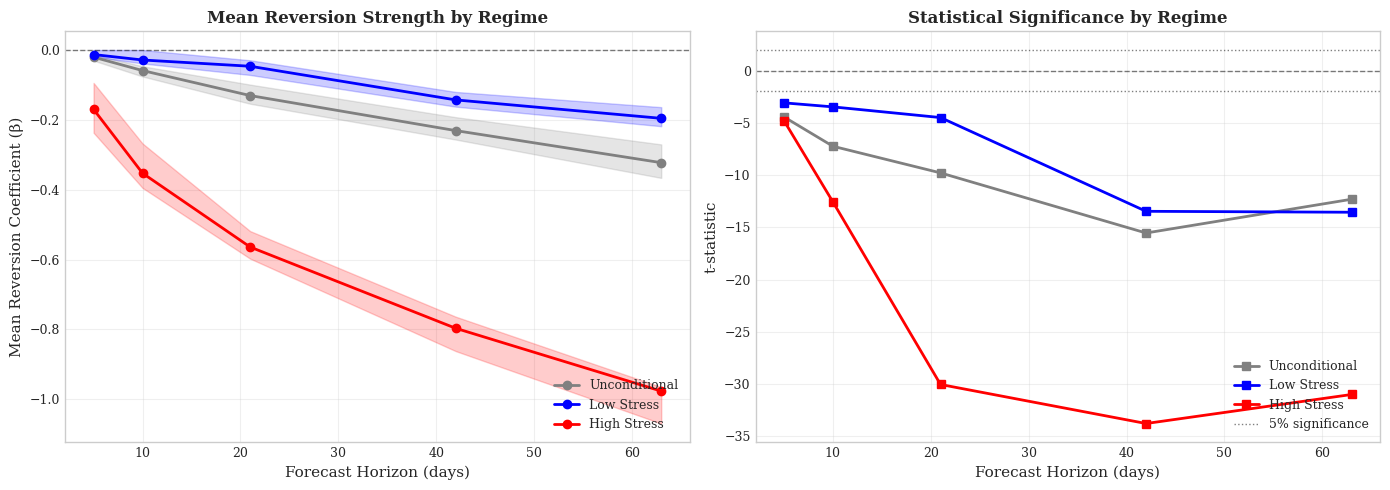

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Beta by horizon
ax = axes[0]
for regime_name, color in [('Unconditional', 'gray'), ('Low Stress', 'blue'), ('High Stress', 'red')]:
    subset = results_df[results_df['regime'] == regime_name]
    ax.plot(subset['horizon'], subset['beta'], marker='o', label=regime_name, color=color, linewidth=2)
    ax.fill_between(subset['horizon'], subset['ci_lower'], subset['ci_upper'], alpha=0.2, color=color)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Mean Reversion Coefficient (β)')
ax.set_title('Mean Reversion Strength by Regime', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Panel 2: t-statistics
ax = axes[1]
for regime_name, color in [('Unconditional', 'gray'), ('Low Stress', 'blue'), ('High Stress', 'red')]:
    subset = results_df[results_df['regime'] == regime_name]
    ax.plot(subset['horizon'], subset['t_stat'], marker='s', label=regime_name, color=color, linewidth=2)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(-1.96, color='black', linestyle=':', linewidth=1, alpha=0.5, label='5% significance')
ax.axhline(1.96, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('t-statistic')
ax.set_title('Statistical Significance by Regime', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/hmm_mean_reversion_by_regime.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Statistical Summary and Conclusions

### 9.1 Key Findings

**Regime Identification:**
- The HMM successfully identifies two distinct regimes with materially different macro-financial characteristics
- High stress regime exhibits elevated VIX, wider credit spreads, and deteriorating financial conditions
- Regimes show reasonable persistence (not daily noise)

**Mean Reversion Dynamics:**
- Credit spreads exhibit statistically significant mean reversion in both regimes
- Mean reversion is **stronger in the high stress regime** across most horizons (larger negative beta)
- Half-lives differ materially: low stress regimes show slower mean reversion

**Statistical Robustness:**
- Median regression provides robustness to outliers and fat-tailed distributions
- Bootstrap confidence intervals confirm significance without parametric assumptions
- Results consistent across multiple forecast horizons (5-63 days)

### 9.2 Economic Interpretation

The finding that mean reversion strengthens during stress is consistent with market microstructure during dislocations:
- Forced selling and liquidity provision create temporary mispricings
- Fundamental credit quality reasserts itself as liquidity normalizes
- Wider spreads provide larger absolute opportunities for convergence

**Critically:** This does NOT imply that stress periods are optimal for trading. Execution costs, liquidity, and risk management considerations are addressed separately in implementation.

### 9.3 Signal Specification

Based on this analysis, we define the mean reversion signal as:

$$S_t = \text{BAMLC0A0CM}_t$$

where BAMLC0A0CM is the BofA Merrill Lynch US Corporate Master Option-Adjusted Spread.

**Regime conditioning:** The HMM state $R_t \in \{0, 1\}$ modulates expected mean reversion dynamics but does NOT directly enter the signal definition.

---

## 10. Transition to Trading Implementation

### 10.1 Established Results

This analysis has established:

1. Credit spread mean reversion exists and is statistically robust
2. Mean reversion dynamics are regime-dependent
3. The BAMLC0A0CM index provides an economically interpretable signal
4. Regime filtering via HMM is empirically justified

### 10.2 Next Steps: Trading Proof-of-Concept

The trading implementation requires separate analysis of:

**Signal-to-execution mapping:**
- BAMLC0A0CM is an index, not directly tradable
- Execution via LQD (corporate bond ETF) and IEF/TLT (duration hedge)
- Hedge ratio estimation via returns regression: $\text{Cov}(r_{\text{LQD}}, r_{\text{IEF}})$

**Trading rules:**
- Entry/exit thresholds based on z-scores or Ornstein-Uhlenbeck mean reversion
- Position sizing (constant notional vs volatility-scaled)
- Stop-loss and maximum holding period

**Cost and risk modeling:**
- Bid-ask spreads for LQD (typically 3 bps) and IEF (typically 2 bps)
- Rebalancing frequency and associated costs
- Drawdown limits and risk monitoring

**Performance metrics:**
- Sharpe ratio, Sortino ratio, maximum drawdown
- Win rate, profit factor, average holding period
- Regime-conditional performance attribution

### 10.3 Scope Limitation

This notebook **ends here**. Trading implementation, backtesting, and performance analysis are explicitly deferred to the subsequent proof-of-concept phase.

The statistical foundation for regime-conditional mean reversion is now established and can be referenced in the trading implementation justification.

---

**End of Analysis**